In [1]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/NYU_Spring_2021/DLS/rl_rec

Mounted at /content/drive
/content/drive/My Drive/NYU_Spring_2021/DLS/rl_rec


In [3]:
import numpy as np
import tensorflow as tf
import sys
import time
import random
import copy
from agent import AgentModel
from environment import EnvModel
from discriminator import DisModel
from utils import FLAGS, load_data, build_vocab, gen_batched_data, PAD_ID, UNK_ID, GO_ID, EOS_ID, _START_VOCAB
import os
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
 # Empty the output file
fout = open(FLAGS['agn_output_file'].value, "w")
fout.close()
fout = open(FLAGS['env_output_file'].value, "w")
fout.close()

In [5]:
# Creating training directory if it does not exist
if not os.path.exists(FLAGS['interact_data_dir'].value):
    os.makedirs(FLAGS['interact_data_dir'].value)
if not os.path.exists(FLAGS['agn_train_dir'].value):
    os.makedirs(FLAGS['agn_train_dir'].value)
if not os.path.exists(FLAGS['env_train_dir'].value):
    os.makedirs(FLAGS['env_train_dir'].value)
if not os.path.exists(FLAGS['dis_train_dir'].value):
    os.makedirs(FLAGS['dis_train_dir'].value)

In [6]:
generate_session, gen_session, gen_rec_list, gen_aims_idx, gen_purchase, session_no, next_session = [], [], [], [], [], 0, True
ini_state = [[[[0.]*FLAGS['units'].value]]*2]*FLAGS['layers'].value
gen_state = ini_state

In [7]:
def select_action(click, state):
    # current_action = [aid2index[item] for item in list(np.random.permutation(vocab[len(_START_VOCAB):])[:FLAGS['action_num'].value])]
    with agn_graph.as_default():
        output = agn_sess.run(
            [agn_model.random_rec_index, agn_model.encoder_state_predict], 
            feed_dict={agn_model.sessions_input: np.reshape(click, [1,1]), 
                    agn_model.sessions_length: np.array([1]),
                    agn_model.lstm_state:state})
    return np.concatenate([np.reshape(output[0], [1, 1, FLAGS['action_num'].value]), np.reshape([EOS_ID], [1,1,1])], 2), output[1]

In [8]:
def rollout(state, click, rollout_list, rollout_rec_list, rollout_aim, rollout_purchase, length):
    rollout_list.append(click)

    with agn_graph.as_default():
        output = agn_sess.run([agn_model.encoder_state_predict, agn_model.random_rec_index], feed_dict={
            agn_model.sessions_input:np.reshape(click, [1,1]),
            agn_model.sessions_length:[1],
            agn_model.lstm_state:state})
        next_state = output[0]
        action = np.concatenate([np.reshape(output[1], [1, 1, FLAGS['action_num'].value]), np.reshape([EOS_ID], [1,1,1])], 2)
        rollout_rec_list.append(action[0,0,:])

    with env_graph.as_default():
        #[1, 1, 10]
        rec_list = np.reshape(rollout_rec_list[-1], [1,1,-1])
        output = env_sess.run([env_model.inf_random_index, env_model.inf_purchase_prob], feed_dict={
            env_model.sessions_input:np.reshape(rollout_list, [1, -1]), 
            env_model.rec_lists:rec_list, 
            env_model.rec_mask:np.ones_like(rec_list),
            env_model.sessions_length:[len(rollout_list)]})

        next_click = rec_list[0,0,output[0][0, -1, 0]]
        rollout_purchase.append(1 if output[1][0, 0, 1] > 0.5 else 0)
        rollout_aim.append(output[0][0,-1,0])

    if len(rollout_list) >= length or click == 3:
        return rollout_list, rollout_rec_list, rollout_aim, rollout_purchase
    return rollout(next_state, next_click, list(rollout_list), list(rollout_rec_list), list(rollout_aim), list(rollout_purchase), length)


In [9]:
def generate_next_click(current_click, flog, use_dis=FLAGS['use_dis'].value):
    global gen_session, gen_rec_list, gen_aims_idx, gen_state, gen_purchase, session_no, next_session

    if len(gen_session) >= max_interact_len or current_click == 3:
        gen_session = [np.random.choice(sort_start_click, p=sort_start_click_prob)]
        gen_rec_list, gen_aims_idx, gen_purchase = [], [], []
        gen_state = ini_state
        session_no += 1
        next_session = True
        current_click = gen_session[-1]
        # print("------------next session:%d------------" % (session_no))
    else:
        gen_session.append(current_click)
        next_session = False
    session_click = np.reshape(np.array(gen_session), [1, len(gen_session)])
    action, state = select_action(session_click[0,-1], gen_state)
    # print(flog, "current_click:", current_click)
    gen_state = state

    with env_graph.as_default():
        #[1, 1, 10]
        output = env_sess.run([env_model.inf_random_index, env_model.inf_purchase_prob], feed_dict={
            env_model.sessions_input:session_click, 
            env_model.rec_lists:action, 
            env_model.rec_mask:np.ones_like(action),
            env_model.sessions_length:[len(session_click[0])]})
        next_click = action[0, 0, output[0][0, -1, 0]]
        purchase_prob = output[1][0, 0, 1]
        # print(flog, "next_click:", next_click, "purchase_prob:", purchase_prob, "reward:", 4 if purchase_prob > 0.5 else 1)
        gen_rec_list.append(list(action[0,0,:]))
        gen_aims_idx.append(output[0][0,-1,0])
        gen_purchase.append(1 if purchase_prob > 0.5 else 0)
    dis_reward = 1.
    
    if use_dis:
        with dis_graph.as_default():
            score = []
            rollout_num = 5 if (len(gen_session) < max_interact_len) and (next_click != 3) else 1
            for _ in range(rollout_num):
                tmp_total_click, tmp_total_rec_list, tmp_total_aims_idx, tmp_total_purchase = rollout(gen_state,next_click,list(gen_session), list(gen_rec_list), list(gen_aims_idx), list(gen_purchase), max_interact_len+1)
                prob = dis_sess.run(dis_model.prob, {
                    dis_model.sessions_input:np.reshape(tmp_total_click, [1, -1]),
                    dis_model.sessions_length:np.array([len(tmp_total_click)]),
                    dis_model.rec_lists:np.array([tmp_total_rec_list]),
                    dis_model.rec_mask:np.ones([1,len(tmp_total_click),len(tmp_total_rec_list[-1])]),
                    dis_model.aims_idx:np.reshape(tmp_total_aims_idx, [1, len(tmp_total_click)]),
                    dis_model.purchase:np.reshape(tmp_total_purchase, [1, len(tmp_total_purchase)])
                    })
                score.append(prob[0])
            dis_reward = np.mean(score)
        # print(flog, "dis_reward:%.8f" % dis_reward)

    action = list(action[0,0,:])
    # print(flog, "action:", action)
    return current_click, next_click, action, purchase_prob, dis_reward


In [10]:
def generate_data(size, flog, use_dis=FLAGS['use_dis'].value):
    global generate_session, current_click, session_no, next_session
    tmp_session_no = session_no
    current_click = np.random.choice(sort_start_click, p=sort_start_click_prob)
    while session_no < tmp_session_no + size:
        current_click, next_click, current_action, purchase_prob, dis_reward = generate_next_click(current_click, flog, use_dis=use_dis)
        if not next_session and len(generate_session) > 0:
            generate_session[-1].append({"session_no":session_no, "click":current_click, "rec_list": current_action, "purchase":(0 if purchase_prob<=0.5 else 1), "dis_reward": dis_reward})
        else:
            if len(generate_session) > 0:
                length = len(generate_session[-1])
                for i in range(1, length):
                    generate_session[-1][length-i]["rec_list"] = generate_session[-1][length-i-1]["rec_list"]
                    generate_session[-1][length-i]["purchase"] = generate_session[-1][length-i-1]["purchase"]
                generate_session[-1][0]["rec_list"] = [generate_session[-1][0]["click"]]
                generate_session[-1][0]["purchase"] = 0

            generate_session.append([{"session_no":session_no, "click":current_click, "rec_list": current_action, "purchase":(0 if purchase_prob<=0.5 else 1), "dis_reward": dis_reward}])
        current_click = next_click
    next_session = True
    if len(generate_session) > FLAGS['pool_size'].value:
        generate_session = generate_session[-FLAGS['pool_size'].value:]


In [11]:
config = tf.ConfigProto(device_count={'GPU':1}) # configuration of cpu/gpu, set which GPUs are to be used using gpu numbers
# config.gpu_options.allow_growth = True # dynamically grow the memory used on the gpu
env_graph = tf.Graph()
agn_graph = tf.Graph()
dis_graph = tf.Graph()
env_sess = tf.Session(config=config, graph=env_graph)
agn_sess = tf.Session(config=config, graph=agn_graph)
dis_sess = tf.Session(config=config, graph=dis_graph)


In [12]:
def load_data1(path, fname):
    session = {}
    output_session = []
    print("Reading data from: %s/%s" % (path, fname))
    with open("%s/%s"%(path,fname), "r") as fin:
        for line in fin:
            tmp = line.strip().split(";")
            # tmp[0] is key unique for each session, a session can have many rows(interactions)
            if int(tmp[0]) in session: # the session is already initialized
                session[int(tmp[0])].append(
                    {"click": tmp[2],
                    "rec_list": tmp[3].strip().split(","),
                    "purchase": int(tmp[4].strip()),
                    "dis_reward":1.})
            else: # initialize the session with the first data point
                session[int(tmp[0])] = [
                    {"click": tmp[2],
                    "rec_list": tmp[3].strip().split(","),
                    "purchase": int(tmp[4].strip()),
                    "dis_reward":1.}]
            if session[int(tmp[0])][-1]["click"] not in session[int(tmp[0])][-1]["rec_list"]: # if the clicked item is not part of reccommeded list in the dataset , add it
                session[int(tmp[0])][-1]["rec_list"] += [session[int(tmp[0])][-1]["click"]]
        skey = sorted(session.keys())
        for key in skey:
            if len(session[key]) > 1 and len(session[key]) <= 40: # take only that session which has length in range [2, 40]
                output_session.append(session[key])
        print("Number of sessions after filtering:", len(output_session))
        # print(output_session)
    return output_session # output_session is list of sessions, each interaction in session is a dictionary


In [13]:
data = load_data1(FLAGS['data_dir'].value, FLAGS['data_name'].value) # load data from the specified directory and file mentioned in utils.py
data = np.random.permutation(data) # randomize the order of data points



Reading data from: ./data/simulated/output.txt
Number of sessions after filtering: 1000


In [14]:
max_interact_len = 2 * int(np.mean([len(s) for s in data]))
print("Average length of the dataset:", np.mean([len(s) for s in data]), "max_interact_len:", max_interact_len)
fold = len(data) // 40 # divide into 40 batches
data_train = data[:(fold * 38)] # 38 batches for training
data_dev = data[(fold * 38):(fold * 39)] # one batch for validation
data_test = data[(fold * 39):] # one batch for testing

vocab, embed = build_vocab(data_train) # get list of clicked items, rewards corresponding to each clicked item and 50 actions
aid2index = {} # clicked items as key and index as value
index2aid = {} # index as key and clicked items as value in data
for i,a in enumerate(vocab):
    aid2index[a] = i
    index2aid[i] = a

Average length of the dataset: 5.134 max_interact_len: 10
Creating vocabulary...


In [15]:
if FLAGS['use_simulated_data'].value: # if using simulated data
    sort_start_click = [data[0][0]["click"]]
    sort_start_click_prob = [1.]
else:
    start_click = {} # how many times has a starting item been clicked for each session
    # first clicked item in each session
    for d in data:
        if d[0]["click"] in aid2index: # if clicked item is in the click2index dict
            k = aid2index[d[0]["click"]]
        else:
            continue
        if k in start_click:
            start_click[k] += 1
        else:
            start_click[k] = 1
    # sort all the first clicked item of each session using values (how many times it has been clicked)
    sort_start_click = sorted(start_click, key=start_click.get, reverse=True)
    # using the frequency of first clicked item of each session calculate probability
    sort_start_click_prob = np.array([start_click[item] for item in sort_start_click]) / float(np.sum([start_click[item] for item in sort_start_click]))

In [16]:
def filter(d):
    new_d = []
    for i, s in enumerate(d): # index, session in passed data
        tmps = []
        for c in s: # for each interaction
            # store the clicked item's index if it's in click2index list otherwise store UNK_ID or 1
            c["click"] = aid2index[c["click"]] if c["click"] in aid2index else UNK_ID
            # for each item in recommended list, if it's been clicked store it's index from click2index
            c["rec_list"] = list(set([aid2index[rl] if rl in aid2index else UNK_ID for rl in c["rec_list"]])) + [EOS_ID]
            tmps.append(c)
        new_d.append(tmps)
    d = copy.deepcopy(new_d)
    return d

data_train = filter(data_train) # 950
data_dev = filter(data_dev) # 25
data_test = filter(data_test) # 25
# interaction will look like this
# {'click': 12, 'rec_list': [1, 12, 13, 14, 15, 16, 3], 'purchase': 0, 'dis_reward': 1.0}

In [17]:
# here average length means average interactions among sessions
print("Get training data: number is %d, average length of session is %.4f" % (len(data_train), np.mean([len(s) for s in data_train])))
print("Get validation data: number is %d, average length of session is %.4f" % (len(data_dev), np.mean([len(s) for s in data_dev])))
print("Get testing data: number is %d, average length of session is %.4f" % (len(data_test), np.mean([len(s) for s in data_test])))

Get training data: number is 950, average length of session is 5.1158
Get validation data: number is 25, average length of session is 5.7200
Get testing data: number is 25, average length of session is 5.2400


In [18]:
with agn_graph.as_default():
    agn_model = AgentModel(
            num_items=len(embed),
            num_embed_units=FLAGS.embed_units,
            num_units=FLAGS.units,
            num_layers=FLAGS.layers,
            embed=embed,
            action_num=FLAGS.action_num)
    agn_model.print_parameters()
    if tf.train.get_checkpoint_state(FLAGS.agn_train_dir):
        print("Reading agent model parameters from %s" % FLAGS.agn_train_dir)
        agn_model.saver.restore(agn_sess, tf.train.latest_checkpoint(FLAGS.agn_train_dir))
    else:
        print("Creating agent model with fresh parameters.")
        agn_sess.run(tf.global_variables_initializer())

agn/embed:0: (54, 50)
agn/encoder/multi_rnn_cell/cell_0/lstm_cell/kernel:0: (562, 2048)
agn/encoder/multi_rnn_cell/cell_0/lstm_cell/bias:0: (2048,)
agn/encoder/multi_rnn_cell/cell_1/lstm_cell/kernel:0: (1024, 2048)
agn/encoder/multi_rnn_cell/cell_1/lstm_cell/bias:0: (2048,)
agn/decoder/output_projection/weights:0: (512, 54)
agn/decoder/output_projection/biases:0: (54,)
Reading agent model parameters from ./train/agn_train


In [19]:
if FLAGS['interact'].value: # True to use online model-based training
    with env_graph.as_default():
        env_model = EnvModel(
                num_items=len(embed),
                num_embed_units=FLAGS['embed_units'].value,
                num_units=FLAGS['units'].value,
                num_layers=FLAGS['layers'].value,
                vocab=vocab,
                embed=embed)
        env_model.print_parameters()
        if tf.train.get_checkpoint_state(FLAGS['env_train_dir'].value):
            print("Reading environment model parameters from %s" % FLAGS['env_train_dir'].value)
            env_model.saver.restore(env_sess, tf.train.latest_checkpoint(FLAGS['env_train_dir'].value))
        else:
            print("Creating environment model with fresh parameters.")
            env_sess.run(tf.global_variables_initializer())


env/embed:0: (54, 50)
env/encoder/multi_rnn_cell/cell_0/lstm_cell/kernel:0: (562, 2048)
env/encoder/multi_rnn_cell/cell_0/lstm_cell/bias:0: (2048,)
env/encoder/multi_rnn_cell/cell_1/lstm_cell/kernel:0: (1024, 2048)
env/encoder/multi_rnn_cell/cell_1/lstm_cell/bias:0: (2048,)
env/pref_output/kernel:0: (512, 50)
env/pref_output/bias:0: (50,)
Reading environment model parameters from ./train/env_train


In [20]:
    if FLAGS['use_dis'].value:
        with dis_graph.as_default():
            dis_model = DisModel(
                    num_items=len(embed),
                    num_embed_units=FLAGS['embed_units'].value,
                    num_units=FLAGS['units'].value,
                    num_layers=FLAGS['layers'].value,
                    vocab=vocab,
                    embed=embed)
            dis_model.print_parameters()
            if tf.train.get_checkpoint_state(FLAGS['dis_train_dir'].value):
                print("Reading discriminator model parameters from %s" % FLAGS['dis_train_dir'].value)
                dis_model.saver.restore(dis_sess, tf.train.latest_checkpoint(FLAGS['dis_train_dir'].value))
            else:
                print("Creating discriminator model with fresh parameters.")
                dis_sess.run(tf.global_variables_initializer())

dis/embed:0: (54, 50)
dis/encoder/multi_rnn_cell/cell_0/lstm_cell/kernel:0: (562, 2048)
dis/encoder/multi_rnn_cell/cell_0/lstm_cell/bias:0: (2048,)
dis/encoder/multi_rnn_cell/cell_1/lstm_cell/kernel:0: (1024, 2048)
dis/encoder/multi_rnn_cell/cell_1/lstm_cell/bias:0: (2048,)
dis/out2preference/kernel:0: (512, 512)
dis/out2preference/bias:0: (512,)
dis/rec2candidate/kernel:0: (50, 512)
dis/rec2candidate/bias:0: (512,)
Reading discriminator model parameters from ./train/dis_train


In [34]:
best_env_train_acc, best_env_train_acc_1 = 0., 0.
test_env_pre = open("test_env_mix.txt", "w")
dev_env_pre = open("dev_env_mix.txt", "w")

dev_loss_env = []
dev_prloss_env = []
dev_puloss_env = []
dev_acc10_env = []
dev_acc1_env = []

def env_train(size, pg=False):
    global best_env_train_acc, best_env_train_acc_1
    pre_losses = [1e18] * 3
    for epoch in range(size):
        with env_graph.as_default():
            start_time = time.time()
            if pg:
                loss = env_model.pg_train(env_sess, generate_session)
                pr_loss, pu_loss = 0, 0
            else:
                loss, pr_loss, pu_loss, _, _ = env_model.train(env_sess, data_train)
            if loss > max(pre_losses):  # Learning rate decay
                env_sess.run(env_model.learning_rate_decay_op)
            pre_losses = pre_losses[1:] + [loss]
            # print("Env epoch %d lr %.4f time %.4f ppl [%.8f] pr_loss [%.8f] pu_loss [%.8f]" \
            #       % (env_model.epoch.eval(session=env_sess), env_model.learning_rate.eval(session=env_sess), time.time() - start_time, loss, pr_loss, pu_loss))
            loss, pr_loss, pu_loss, acc, acc_1 = env_model.train(env_sess, data_dev, is_train=False)
            # print("dev_set, ppl [%.8f] pr_loss [%.8f] pu_loss [%.8f] best_p@%d [%.4f]" % (loss, pr_loss, pu_loss, FLAGS['metric'].value, best_env_train_acc))
            print("Dev Epoch: %d,Loss: %.3f,pr_loss: %.3f,pu_loss: %.3f,p_value: %d,%.3f,Accuracy_10: %.3f,Accuracy_1: %.3f\n" %(epoch,loss, pr_loss, pu_loss,FLAGS['metric'].value,acc*100,acc_1*100,best_env_train_acc))
            dev_env_pre.write("%d,%.3f,%.3f,%.3f,%d,%.3f,%.3f,%.3f\n" %(epoch,loss, pr_loss, pu_loss,FLAGS['metric'].value,acc*100, acc_1*100,best_env_train_acc))
            dev_loss_env.append(loss)
            dev_prloss_env.append(pr_loss)
            dev_puloss_env.append(pu_loss)
            dev_acc10_env.append(acc)
            dev_acc1_env.append(acc_1)
            
            if acc > best_env_train_acc or acc_1 > best_env_train_acc_1:
                if acc > best_env_train_acc: best_env_train_acc = acc
                if acc_1 > best_env_train_acc_1: best_env_train_acc_1 = acc_1
                loss, pr_loss, pu_loss, acct, acct1 = env_model.train(env_sess, data_test, is_train=False)
                # print("test_set, ppl [%.8f] pr_loss [%.8f] pu_loss [%.8f] best_p@%d [%.4f]" % (loss, pr_loss, pu_loss, FLAGS['metric'].value, best_env_train_acc))
                print("Test Epoch: %d,Loss: %.3f,pr_loss: %.3f,pu_loss: %.3f,p_value: %d,%.3f,Accuracy_10: %.3f,Accuracy_1: %.3f\n" %(epoch,loss, pr_loss, pu_loss,FLAGS['metric'].value,acct*100,acct1*100,best_env_train_acc))
                test_env_pre.write("%d,%.3f,%.3f,%.3f,%d,%.3f,%.3f,%.3f\n" %(epoch,loss, pr_loss, pu_loss,FLAGS['metric'].value,acct*100,acct1*100,best_env_train_acc))
                
                env_model.saver.save(env_sess, '%s/checkpoint' % FLAGS['env_train_dir'].value, global_step=env_model.global_step)
                print("Saving env model params in %s" % FLAGS['env_train_dir'].value)
            print("------env %strain finish-------"%("pg " if pg else ""))


In [25]:
best_agn_train_acc, best_agn_train_acc_1 = 0., 0.
test_agn_pre = open("test_agn_mix.txt", "w")
dev_agn_pre = open("dev_agn_mix.txt", "w")
dev_loss_agn = []
dev_acc10_agn = []
dev_acc1_agn = []

def agn_train(size):
    global best_agn_train_acc, best_agn_train_acc_1
    for epoch in range(size):
        with agn_graph.as_default():
            start_time = time.time()
            loss, acc, acc_1 = agn_model.train(agn_sess, data_train, generate_session)
            # print("Agn epoch %d learning rate %.4f epoch-time %.4f loss [%.8f] p@%d %.4f%% p@1 %.4f%%" \
            #         % (agn_model.epoch.eval(session=agn_sess), agn_model.learning_rate.eval(session=agn_sess), time.time() - start_time, loss, FLAGS['metric'].value, acc*100, acc_1*100))
            loss, acc, acc_1 = agn_model.train(agn_sess, data_dev, is_train=False)
            # print("dev_set, loss [%.8f] p@%d %.4f%% p@1 %.4f%%" % (loss, FLAGS['metric'].value, acc*100, acc_1*100))

            print("Dev Epoch: %d,Loss: %.3f,p value: %d,Accuracy_10: %.3f,Accuracy_1: %.3f\n" %(epoch,loss,FLAGS['metric'].value,acc*100, acc_1*100))
            dev_agn_pre.write("%d,%.3f,%d,%.3f,%.3f\n" %(epoch,loss,FLAGS['metric'].value,acc*100, acc_1*100))
            dev_loss_agn.append(loss)
            dev_acc10_agn.append(acc)
            dev_acc1_agn.append(acc_1)

            if acc > best_agn_train_acc or acc_1 > best_agn_train_acc_1:
                if acc > best_agn_train_acc: best_agn_train_acc = acc
                if acc_1 > best_agn_train_acc_1: best_agn_train_acc_1 = acc_1
                loss, acc, acc_1 = agn_model.train(agn_sess, data_test, is_train=False)
                # print("test_set, loss [%.8f] p@%d %.4f%% p@1 %.4f%%" % (loss, FLAGS['metric'].value, acc*100, acc_1*100))
                print("Test Epoch: %d,Loss: %.3f, p value: %d,Accuracy_10: %.3f,Accuracy_1: %.3f\n" %(epoch,loss,FLAGS['metric'].value,acc*100, acc_1*100))
                test_agn_pre.write("%d,%.3f,%d,%.3f,%.3f\n" %(epoch,loss,FLAGS['metric'].value,acc*100, acc_1*100))

                agn_model.saver.save(agn_sess, '%s/checkpoint' % FLAGS['agn_train_dir'].value, global_step=agn_model.global_step)
                print("Saving agn model params in %s" % FLAGS['agn_train_dir'].value)
            print("------agn train finish-------")

In [26]:
discr_training = open("discr_training_mix.txt", "w")
train_acc_discr = []
train_loss_discr = []

def dis_train(size):
    random_generate_session = np.random.permutation(generate_session).tolist()
    for epoch in range(size):
        with dis_graph.as_default():
            start_time = time.time()
            loss, acc = dis_model.train(data_train, random_generate_session, sess=dis_sess)
            dis_model.saver.save(dis_sess, '%s/checkpoint' % FLAGS['dis_train_dir'].value, global_step=dis_model.global_step)
            # print("Dis epoch %d learning rate %.4f epoch-time %.4f perplexity [%.8f] acc %.4f%%" \
            #         % (dis_model.epoch.eval(session=dis_sess), dis_model.learning_rate.eval(session=dis_sess), time.time() - start_time, loss, acc*100))
            
            print("Epoch: %d,LR: %.4f, Loss: %.3f,Accuracy: %.3f\n" %(epoch,dis_model.learning_rate.eval(session=dis_sess),loss, acc*100))
            discr_training.write("%d,%.4f,%.3f,%.3f\n" %(epoch,dis_model.learning_rate.eval(session=dis_sess),loss, acc*100))
            train_loss_discr.append(loss)
            train_acc_discr.append(acc)

            print("------dis train finish-------")


In [27]:
def interact(size, use_dis=FLAGS['use_dis'].value):
    start_time = time.time()
    with open("%s/train_log_%d.txt"%(FLAGS['interact_data_dir'].value, session_no), "w") as flog:
        generate_data(size, flog, use_dis=use_dis)
    print("%d interactions finished after %.4fs " % (size, time.time()-start_time))


In [28]:
# Pretraining (replace number of epoch to 50 by 2)
agn_train(50) # train agent for 50 epochs

Dev Epoch: 0,Loss: 29.242,p value: 10,Accuracy_10: 100.000,Accuracy_1: 26.271

Test Epoch: 0,Loss: 25.315, p value: 10,Accuracy_10: 100.000,Accuracy_1: 21.698

Saving agn model params in ./train/agn_train
------agn train finish-------
Dev Epoch: 1,Loss: 29.446,p value: 10,Accuracy_10: 100.000,Accuracy_1: 24.576

------agn train finish-------
Dev Epoch: 2,Loss: 29.723,p value: 10,Accuracy_10: 100.000,Accuracy_1: 22.034

------agn train finish-------
Dev Epoch: 3,Loss: 30.009,p value: 10,Accuracy_10: 100.000,Accuracy_1: 22.881

------agn train finish-------
Dev Epoch: 4,Loss: 30.545,p value: 10,Accuracy_10: 100.000,Accuracy_1: 22.881

------agn train finish-------
Dev Epoch: 5,Loss: 30.819,p value: 10,Accuracy_10: 100.000,Accuracy_1: 20.339

------agn train finish-------
Dev Epoch: 6,Loss: 31.077,p value: 10,Accuracy_10: 100.000,Accuracy_1: 21.186

------agn train finish-------
Dev Epoch: 7,Loss: 30.846,p value: 10,Accuracy_10: 100.000,Accuracy_1: 22.881

------agn train finish-------
De

In [35]:
if FLAGS['interact'].value:
    env_train(50) # train env for 50 epochs



predict:p@1:32.4903% p@10:100.0000%
predict:p@1:20.3390% p@10:100.0000%
Dev Epoch: 0,Loss: 2.417,pr_loss: 2.417,pu_loss: 0.000,p_value: 10,100.000,Accuracy_10: 20.339,Accuracy_1: 0.000

predict:p@1:23.5849% p@10:100.0000%
Test Epoch: 0,Loss: 2.349,pr_loss: 2.349,pu_loss: 0.000,p_value: 10,100.000,Accuracy_10: 23.585,Accuracy_1: 1.000

Saving env model params in ./train/env_train
------env train finish-------
predict:p@1:34.1260% p@10:100.0000%
predict:p@1:18.6441% p@10:100.0000%
Dev Epoch: 1,Loss: 2.455,pr_loss: 2.455,pu_loss: 0.000,p_value: 10,100.000,Accuracy_10: 18.644,Accuracy_1: 1.000

------env train finish-------
predict:p@1:34.9634% p@10:100.0000%
predict:p@1:18.6441% p@10:100.0000%
Dev Epoch: 2,Loss: 2.430,pr_loss: 2.430,pu_loss: 0.000,p_value: 10,100.000,Accuracy_10: 18.644,Accuracy_1: 1.000

------env train finish-------
predict:p@1:36.6584% p@10:100.0000%
predict:p@1:16.9492% p@10:100.0000%
Dev Epoch: 3,Loss: 2.470,pr_loss: 2.470,pu_loss: 0.000,p_value: 10,100.000,Accuracy_

In [36]:
    interact(1000, use_dis=False)


1000 interactions finished after 26.7461s 


In [37]:
    if FLAGS['use_dis'].value:
        dis_train(3) # train dis for 3 epochs

Epoch: 0,LR: 0.0001, Loss: 0.479,Accuracy: 88.395

------dis train finish-------
Epoch: 1,LR: 0.0001, Loss: 0.298,Accuracy: 90.819

------dis train finish-------
Epoch: 2,LR: 0.0001, Loss: 0.238,Accuracy: 93.087

------dis train finish-------


In [38]:
# dev_loss_env = []
# dev_prloss_env = []
# dev_puloss_env = []
# dev_acc10_env = []
# dev_acc1_env = []
# dev_loss_agn = []
# dev_acc10_agn = []
# dev_acc1_agn = []
# train_acc_discr = []
# train_loss_discr = []

print(dev_loss_env)
print(dev_prloss_env)
print(dev_puloss_env)
print(dev_acc10_env)
print(dev_acc1_env)
print(dev_loss_agn)
print(dev_acc10_agn)
print(dev_acc1_agn)
print(train_acc_discr)
print(train_loss_discr)


[2.4171655, 2.4550898, 2.4296367, 2.470052, 2.5081275, 2.5225046, 2.6212518, 2.642908, 2.576352, 2.5354333, 2.6397407, 2.8585055, 2.8610585, 2.6263824, 2.6363375, 2.6833723, 2.697916, 2.804398, 2.74931, 2.7154841, 2.7474773, 2.7544625, 2.9540024, 2.8531618, 2.7542336, 2.8776069, 2.985118, 2.982348, 3.023364, 3.0730474, 3.095971, 3.124224, 3.1881704, 3.2278128, 3.312116, 3.342123, 3.4030793, 3.4734032, 3.4780638, 3.5322685, 3.5648537, 3.5496025, 3.545351, 3.5214376, 3.4674177, 3.4025013, 3.3354967, 3.3044915, 3.2944503, 3.288308]
[2.4171655, 2.4550898, 2.4296367, 2.470052, 2.5081275, 2.5225046, 2.6212518, 2.642908, 2.576352, 2.5354333, 2.6397407, 2.8585055, 2.8610585, 2.6263824, 2.6363375, 2.6833723, 2.697916, 2.804398, 2.74931, 2.7154841, 2.7474773, 2.7544625, 2.9540024, 2.8531618, 2.7542336, 2.8776069, 2.985118, 2.982348, 3.023364, 3.0730474, 3.095971, 3.124224, 3.1881704, 3.2278128, 3.312116, 3.342123, 3.4030793, 3.4734032, 3.4780638, 3.5322685, 3.5648537, 3.5496025, 3.545351, 3.5214

In [39]:
# Adversarial training
generate_session = []
pre_losses = [1e18] * 3
epochs = 0
while epochs < 20 :
    print('************* Epoch', epochs,'*****************')
    for _ in range(3):
        for _ in range(3):
            if FLAGS['interact'].value:
                interact(200)
            agn_train(1)

        if FLAGS['use_dis'].value:
            env_train(1, pg=True)
            env_train(1)
    if FLAGS['use_dis'].value:
        dis_train(3)
    
    epochs += 1
    print("*"*25)

************* Epoch 0 *****************
200 interactions finished after 128.7728s 
Dev Epoch: 0,Loss: 35.668,p value: 10,Accuracy_10: 100.000,Accuracy_1: 16.949

------agn train finish-------
200 interactions finished after 128.6932s 
Dev Epoch: 0,Loss: 35.868,p value: 10,Accuracy_10: 100.000,Accuracy_1: 14.407

------agn train finish-------
200 interactions finished after 145.0138s 
Dev Epoch: 0,Loss: 36.733,p value: 10,Accuracy_10: 100.000,Accuracy_1: 13.559

------agn train finish-------
Get training data:len(dataset) is 601 
predict:p@1:11.0169% p@10:100.0000%
Dev Epoch: 0,Loss: 3.373,pr_loss: 3.373,pu_loss: 0.000,p_value: 10,100.000,Accuracy_10: 11.017,Accuracy_1: 1.000

------env pg train finish-------
predict:p@1:64.6664% p@10:100.0000%
predict:p@1:16.1017% p@10:100.0000%
Dev Epoch: 0,Loss: 3.230,pr_loss: 3.230,pu_loss: 0.000,p_value: 10,100.000,Accuracy_10: 16.102,Accuracy_1: 1.000

------env train finish-------
200 interactions finished after 142.3255s 
Dev Epoch: 0,Loss: 36.6

KeyboardInterrupt: ignored

In [40]:
print(dev_loss_env)
print(dev_prloss_env)
print(dev_puloss_env)
print(dev_acc10_env)
print(dev_acc1_env)
print(dev_loss_agn)
print(dev_acc10_agn)
print(dev_acc1_agn)
print(train_acc_discr)
print(train_loss_discr)

[2.4171655, 2.4550898, 2.4296367, 2.470052, 2.5081275, 2.5225046, 2.6212518, 2.642908, 2.576352, 2.5354333, 2.6397407, 2.8585055, 2.8610585, 2.6263824, 2.6363375, 2.6833723, 2.697916, 2.804398, 2.74931, 2.7154841, 2.7474773, 2.7544625, 2.9540024, 2.8531618, 2.7542336, 2.8776069, 2.985118, 2.982348, 3.023364, 3.0730474, 3.095971, 3.124224, 3.1881704, 3.2278128, 3.312116, 3.342123, 3.4030793, 3.4734032, 3.4780638, 3.5322685, 3.5648537, 3.5496025, 3.545351, 3.5214376, 3.4674177, 3.4025013, 3.3354967, 3.3044915, 3.2944503, 3.288308, 3.3732936, 3.2298188, 3.2755153, 3.0567114, 3.203455, 3.0721214, 3.1885862, 3.0950682, 3.3957686, 3.1609554, 3.41907, 3.3106594, 3.4881296, 3.2809906, 3.5943167, 3.4038413, 3.6060553, 3.3810802, 3.6970804, 3.5077333, 3.741549, 3.6591246, 3.755612, 3.6886644, 3.8347692, 3.7792926, 3.9276, 3.8057344, 3.8806098, 3.7452042, 3.9435635, 3.8694143, 4.146379, 3.8374035, 4.1305213, 3.8964548, 4.1314416, 3.93676, 4.1838965, 4.000628, 4.1688457, 4.015448]
[2.4171655, 2.45

In [41]:
print(len(dev_loss_env))
print(len(dev_prloss_env))
print(len(dev_puloss_env))
print(len(dev_acc10_env))
print(len(dev_acc1_env))
print(len(dev_loss_agn))
print(len(dev_acc10_agn))
print(len(dev_acc1_agn))
print(len(train_acc_discr))
print(len(train_loss_discr))

92
92
92
92
92
113
113
113
24
24


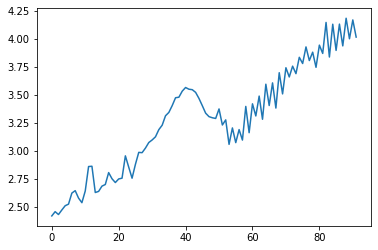

In [42]:
from matplotlib import pyplot as plt

plt.plot(dev_loss_env)

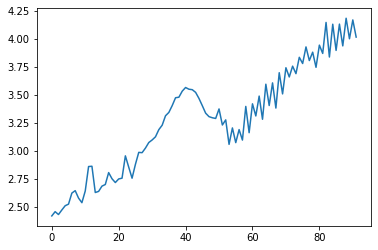

In [47]:
plt.plot(dev_prloss_env)

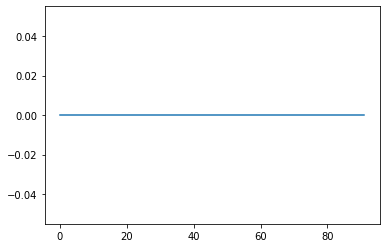

In [48]:
plt.plot(dev_puloss_env)

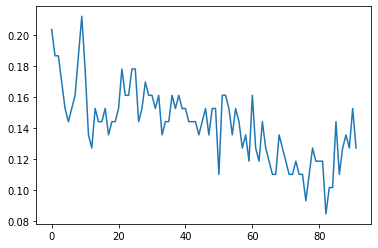

In [44]:
plt.plot(dev_acc1_env)

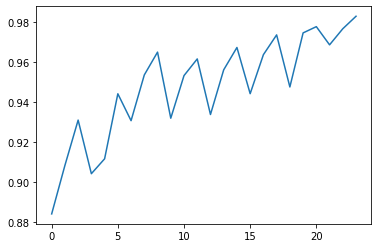

In [45]:
plt.plot(train_acc_discr)

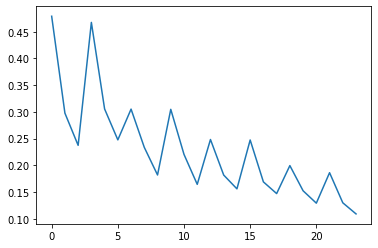

In [46]:
plt.plot(train_loss_discr)